In [1]:
from pystac_client import Client

# Connect to Landsat STAC catalog
catalog = Client.open('https://landsatlook.usgs.gov/stac-server')

# Search for one scene
search = catalog.search(
    collections=['landsat-c2l2-sr'],
    bbox=[-122.5, 37.7, -122.3, 37.9],  # San Francisco
    datetime='2023-06-01/2023-08-31',
    limit=1
)

items = list(search.items())
print(f"Found {len(items)} scene(s)")
print(f"Scene ID: {items[0].id if items else 'None'}")

Found 42 scene(s)
Scene ID: LC09_L2SP_044034_20230826_20230828_02_T1_SR


In [6]:
item = items[0]
print("Assets:")
for asset_key, asset in item.assets.items():
    print(f" - {asset_key}: {asset.href}")

Assets:
 - thumbnail: https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2023/044/034/LC09_L2SP_044034_20230826_20230828_02_T1/LC09_L2SP_044034_20230826_20230828_02_T1_thumb_small.jpeg
 - reduced_resolution_browse: https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2023/044/034/LC09_L2SP_044034_20230826_20230828_02_T1/LC09_L2SP_044034_20230826_20230828_02_T1_thumb_large.jpeg
 - index: https://landsatlook.usgs.gov/stac-browser/collection02/level-2/standard/oli-tirs/2023/044/034/LC09_L2SP_044034_20230826_20230828_02_T1/LC09_L2SP_044034_20230826_20230828_02_T1
 - MTL.json: https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2023/044/034/LC09_L2SP_044034_20230826_20230828_02_T1/LC09_L2SP_044034_20230826_20230828_02_T1_MTL.json
 - coastal: https://landsatlook.usgs.gov/data/collection02/level-2/standard/oli-tirs/2023/044/034/LC09_L2SP_044034_20230826_20230828_02_T1/LC09_L2SP_044034_20230826_20230828_02_T1_SR_B1.TIF
 - blue: htt

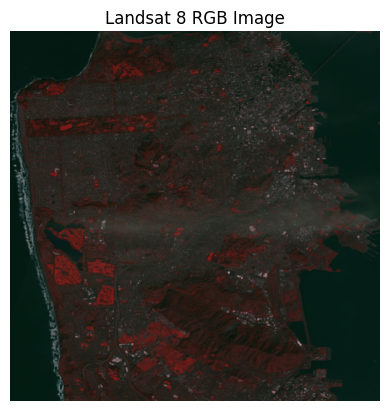

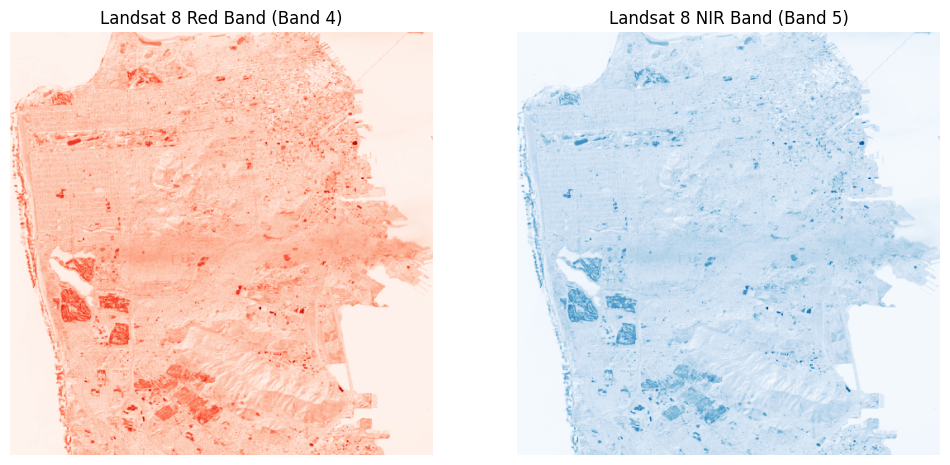

In [10]:
from sentinelhub import SHConfig, SentinelHubRequest, MimeType, CRS, BBox
from sentinelhub import DataCollection, bbox_to_dimensions, SentinelHubDownloadClient
import numpy as np
import matplotlib.pyplot as plt
import json

# Load Sentinel Hub credentials from config file
with open('sentinelhub_config.json', 'r') as f:
    config_data = json.load(f)

config = SHConfig()
config.sh_client_id = config_data['sh_client_id']
config.sh_client_secret = config_data['sh_client_secret']

# Define bounding box (e.g., coordinates of an area of interest)
# Example coordinates (lat, lon): BBox in CRS=EPSG:4326
bbox = BBox(bbox=[-122.517, 37.655, -122.358, 37.808], crs=CRS.WGS84)

# Define the time range for your search (start and end dates)
time_interval = ('2021-02-01', '2021-02-28')

# Define evalscript to select bands (Landsat 8: B04=Red, B03=Green, B02=Blue, B05=NIR)
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B04", "B03", "B02", "B05"],
    output: { bands: 4 }
  };
}
function evaluatePixel(sample) {
  return [sample.B04, sample.B03, sample.B02, sample.B05];
}
"""

# Query for Landsat 8 imagery (You can use other datasets as well)
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,
            time_interval=time_interval,
            maxcc=0.2
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=(512, 512),  # Image size in pixels
    config=config
)

# Download the image
data = request.get_data()

# Show the image (RGB bands)
plt.imshow(data[0][:, :, [3, 2, 1]])  # Red, Green, Blue channels (Landsat 8 bands)
plt.title('Landsat 8 RGB Image')
plt.axis('off')
plt.show()

# You can also inspect individual bands
# For example, let's inspect the red (Band 4) and near-infrared (Band 5) bands
plt.figure(figsize=(12, 6))

# Red Band (Band 4)
plt.subplot(1, 2, 1)
plt.imshow(data[0][:, :, 3], cmap='Reds')
plt.title('Landsat 8 Red Band (Band 4)')
plt.axis('off')

# NIR Band (Band 5)
plt.subplot(1, 2, 2)
plt.imshow(data[0][:, :, 3], cmap='Blues')
plt.title('Landsat 8 NIR Band (Band 5)')
plt.axis('off')

plt.show()
